In [ ]:
#Importing Liraries

# Importing Libraries
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import shutil
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
import random
import joblib
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from scipy.sparse import hstack
from wordcloud import WordCloud


# Utilities
#from viz_utils import *
#from custom_transformers import *
#from ml_utils import *

# DataPrep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import Normalizer

# Modeling

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier, AdaBoostClassifier
#Metrics
from sklearn.metrics import log_loss,accuracy_score, confusion_matrix, f1_score





#Importing the Libraries
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/case study

/content/drive/MyDrive/case study


In [ ]:
X_train = pickle.load(open('X_train.pkl','rb'))
X_test = pickle.load(open('X_test.pkl','rb'))

In [ ]:
X_train.head()

,order_status,payment_sequential,payment_type,payment_installments,payment_value,customer_zip_code_prefix,customer_city,customer_state,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_comment_message,day_to_delivery,words_per_review,sellers_count,products_count,est_delivery_t,act_delivery_t,diff_in_delivery_t,on_time_delivery,avg_prdt_value,total_order_cost,order_freight_ratio,purchase_dayofweek,is_reviewed,recency,frequency,monetary,RFM_Level
28832,delivered,1,boleto,1,95.21,13211,jundiai,SP,79.90,15.31,21.0,663.0,2.0,100.0,16.0,16.0,11.0,computers_accessories,neg _revej,22,1,6,1,31,19,12,1,79.90,95.21,0.191615,0,1,202,1,95.21,Potential
28103,delivered,1,credit_card,1,54.28,8215,sao paulo,SP,45.99,8.29,35.0,221.0,1.0,500.0,16.0,33.0,13.0,garden_tools,neg _revej,2,1,2,1,9,0,9,1,45.99,54.28,0.180257,6,1,133,1,54.28,Promising
76931,delivered,1,credit_card,1,171.62,22745,rio de janeiro,RJ,148.00,23.62,50.0,623.0,1.0,1200.0,19.0,18.0,16.0,sports_leisure,neg _revej,24,1,8,1,34,24,10,1,148.00,171.62,0.159595,3,1,157,1,171.62,Loyal
17603,delivered,1,credit_card,10,139.55,35519,nova serrana,MG,99.90,23.57,57.0,272.0,1.0,2500.0,40.0,10.0,30.0,furniture_decor,neg _revej,10,1,100,1,26,10,16,1,99.90,123.47,0.235936,2,1,200,1,139.55,Loyal
8208,delivered,1,boleto,1,82.91,20261,rio de janeiro,RJ,63.50,19.41,45.0,598.0,3.0,1100.0,33.0,13.0,22.0,perfumery,gost sab pq produt neg entreg gost soluç,33,14,1,1,29,32,-3,0,63.50,82.91,0.305669,3,1,122,1,82.91,Potential


In [ ]:
X_tr = pickle.load(open('X_tr.pkl', 'rb'))
X_te = pickle.load(open('X_te.pkl', 'rb'))
y_train = pickle.load(open('y_train.pkl','rb'))
y_test = pickle.load(open('y_test.pkl','rb'))

In [ ]:
# load the model from file
encoder = load_model('encoder.h5')

# encode the train data
X_train_encode = encoder.predict(X_tr)
print('X_train_encode',X_train_encode.shape)
# encode the test data
X_test_encode = encoder.predict(X_te)
print('X_test_encode',X_test_encode.shape)

X_train_encode (77804, 112)
X_test_encode (19451, 112)


In [ ]:
def confusion_matrices_plot(y_real, y_pred, y_test,y_test_pred,name):
    # representing confusion matric in heatmap format
    # https://seaborn.pydata.org/generated/seaborn.heatmap.html
    cmap_ = sns.light_palette("#425a90",as_cmap=True)
    cmap = sns.light_palette("#000000",as_cmap=True)
    C1 = confusion_matrix(y_real,y_pred)
    C2 = confusion_matrix(y_test,y_test_pred)
    
    fig,ax = plt.subplots(1, 2, figsize=(15,5))
    ax1 = sns.heatmap(C1, annot=True, cmap=cmap, fmt=".2f", ax = ax[0])
    ax1.set_xlabel('Predicted Class')
    ax1.set_ylabel('Original Class')
    ax1.set_title("Train Confusion matrix")

    ax2 = sns.heatmap(C2, annot=True, cmap=cmap_, fmt=".2f", ax = ax[1])
    ax2.set_xlabel('Predicted Class')
    ax2.set_ylabel('Original Class')
    ax2.set_title("Test Confusion matrix")
    plt.savefig(name, dpi=480, bbox_inches='tight')
    plt.show()

# 1.Linear SVM Model

Alpha =  1e-05 Train Score 0.7426881274403494 test Score 0.711429758484188
Alpha =  0.0001 Train Score 0.7969280203375975 test Score 0.7590218036650437
Alpha =  0.001 Train Score 0.7779664010455214 test Score 0.7458017969782127
Alpha =  0.01 Train Score 0.8120023685210596 test Score 0.7670568438912866
Alpha =  0.1 Train Score 0.8454147613073184 test Score 0.7944185654229546
Alpha =  1 Train Score 0.8442628803938433 test Score 0.7930241824437074
Alpha =  10 Train Score 0.8218645706991656 test Score 0.7804407657723436
Alpha =  100 Train Score 0.4684095647897985 test Score 0.4712500475569102
Alpha =  1000 Train Score 0.4549814497049617 test Score 0.4565774667184236


Text(0.5, 1.0, 'Alpha vs Score')

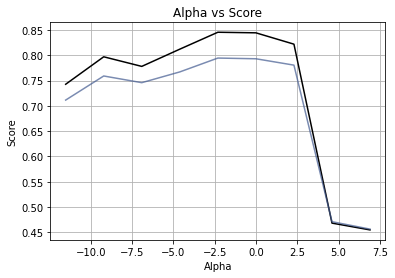

In [ ]:

# Training Logistic regression model and chekcing f1 score metric
alpha = [10 ** x for x in range(-5, 4)]
train_scores = [] # store train scores
test_scores = [] # store test scores

for i in alpha:
    lr = SGDClassifier(loss='hinge', penalty='l2', alpha=i, n_jobs=-1, random_state=25)
    lr.fit(X_train_encode,y_train)
    train_sc = f1_score(y_train,lr.predict(X_train_encode),average='macro')
    test_sc = f1_score(y_test,lr.predict(X_test_encode),average='macro')
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Alpha = ',i,'Train Score',train_sc,'test Score',test_sc)
    
# plotting the scores vs parameters
plt.plot(np.log(alpha),train_scores,label='Train Score',color='black')
plt.plot(np.log(alpha),test_scores,label='Test Score',color='#425a90',alpha=0.7)
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.grid()
plt.title('Alpha vs Score')

In [ ]:
# Parameter tuning of Logistic regression using RandomisedSearch CV technique
sgd = SGDClassifier(loss='hinge', n_jobs=-1, random_state=25)
 
prams={ 'alpha': [10 ** x for x in range(-5, 4)] }

random_cfl1 = RandomizedSearchCV(sgd,param_distributions=prams,verbose=10,scoring='f1_macro',n_jobs=-1,random_state=25,
                               return_train_score=True)
random_cfl1.fit(X_train_encode,y_train)

print('mean test scores',random_cfl1.cv_results_['mean_test_score'])
print('mean train scores',random_cfl1.cv_results_['mean_train_score'])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.6min finished


mean test scores [0.81283792 0.81544242 0.79118321 0.81786007 0.84249014 0.85295023
 0.83787149 0.47277831 0.46096543]
mean train scores [0.81428754 0.81534436 0.79081021 0.81915052 0.84231144 0.85361772
 0.8377479  0.47326957 0.46096551]


In [ ]:
# printing best parameters and score
print("Best Parameters: ",random_cfl1.best_params_)
print("Best Score: ",random_cfl1.best_score_)

Best Parameters:  {'alpha': 1}
Best Score:  0.852950225246062


In [ ]:
# Fitting LogisticRegression mpdel on best parameters
sgd = SGDClassifier(loss='hinge', alpha=1, n_jobs=-1, random_state=25)
sgd.fit(X_train_encode,y_train)


y_train_pred = sgd.predict(X_train_encode)
y_test_pred = sgd.predict(X_test_encode)

# printing train and test scores 
print('Train f1 score: ',f1_score(y_train,y_train_pred,average='macro'))
print('Test f1 score: ',f1_score(y_test,y_test_pred,average='macro'))

Train f1 score:  0.8442628803938433
Test f1 score:  0.7930241824437074


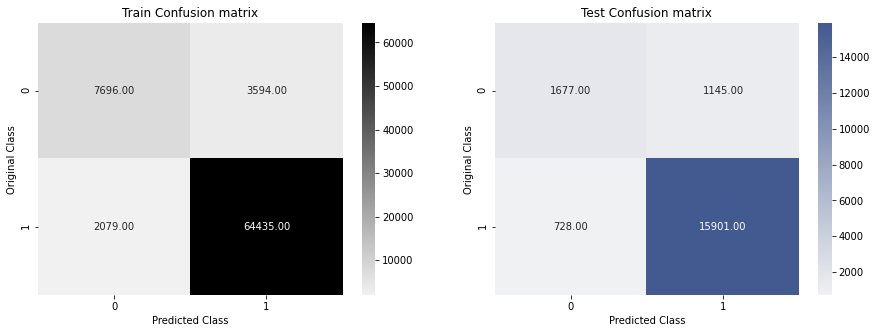

In [ ]:
confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred,'svm.png')

In [ ]:
#saving the model
filename = '/content/drive/MyDrive/case study/models/svm.sav'
joblib.dump(sgd, filename)

['/content/drive/MyDrive/case study/models/svm.sav']

### 2.Decision Tree

Depth =  3 Train Score 0.8410443354270485 test Score 0.7823336186969845
Depth =  10 Train Score 0.8944223553640378 test Score 0.8011274038641633
Depth =  50 Train Score 0.9607451887375799 test Score 0.7674886074762987
Depth =  100 Train Score 0.9607703670756125 test Score 0.7669917560036371
Depth =  250 Train Score 0.9607703670756125 test Score 0.7669917560036371
Depth =  500 Train Score 0.9607703670756125 test Score 0.7669917560036371


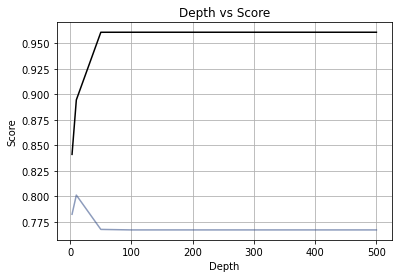

In [ ]:
# Checking the variation of score with depth parameters of Decision Tree
depth = [3,10,50,100,250,500]
train_scores = []
test_scores = []
for i in depth:
    clf = DecisionTreeClassifier(max_depth=i,random_state=25)
    clf.fit(X_train_encode,y_train)
    train_sc = f1_score(y_train,clf.predict(X_train_encode),average='macro')
    test_sc = f1_score(y_test,clf.predict(X_test_encode),average='macro')
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Depth = ',i,'Train Score',train_sc,'test Score',test_sc)

# plotting the score vs depth
plt.plot(depth,train_scores,label='Train Score',color='black')
plt.plot(depth,test_scores,label='Test Score',color='#425a90',alpha=0.6)
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs Score')
plt.grid()
plt.show()

In [ ]:
# Parameter tuning of DecisionTreeClassifier using RandomisedSearch CV technique
# https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3
dt = DecisionTreeClassifier(random_state=25)

params = { "max_depth": sp_randint(3,500), "min_samples_split": sp_randint(50,200), "min_samples_leaf": sp_randint(2,50)}

random_cfl1 = RandomizedSearchCV(dt, param_distributions=params,verbose=10,scoring='f1_macro',n_jobs=-1,random_state=25,
                               return_train_score=True)
random_cfl1.fit(X_train_encode,y_train)

print('mean test scores',random_cfl1.cv_results_['mean_test_score'])
print('mean train scores',random_cfl1.cv_results_['mean_train_score'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 10.0min finished


mean test scores [0.86400205 0.86391897 0.85812082 0.86370056 0.85713902 0.85693981
 0.84822633 0.86139325 0.86204052 0.85989181]
mean train scores [0.8758983  0.87667336 0.8817508  0.87602165 0.88223669 0.88235182
 0.89540709 0.88088749 0.87740286 0.87909035]


In [ ]:
# printing best parameters and scores
print("Best Parameters: ",random_cfl1.best_params_)
print("Best Score: ",random_cfl1.best_score_)

Best Parameters:  {'max_depth': 135, 'min_samples_leaf': 28, 'min_samples_split': 193}
Best Score:  0.8640020459676931


In [ ]:
# Fitting the model on best parameters
dt = DecisionTreeClassifier(max_depth = 135, min_samples_leaf = 28, min_samples_split = 193,random_state=25)
dt.fit(X_train_encode,y_train)

y_train_pred = dt.predict(X_train_encode)
y_test_pred = dt.predict(X_test_encode)

# printing train test score
print('Train f1 score',f1_score(y_train,y_train_pred,average='macro'))
print('Test f1 score',f1_score(y_test,y_test_pred,average='macro'))

Train f1 score 0.8774934888896901
Test f1 score 0.8028745314241124


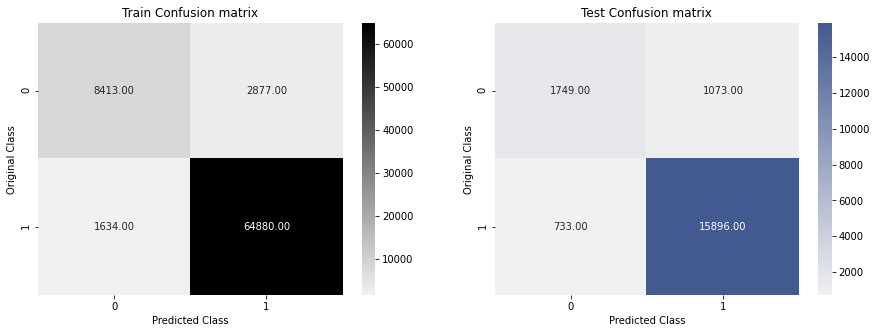

In [ ]:
confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred,'dt.png')

In [ ]:
#saving the model
filename = '/content/drive/MyDrive/case study/models/dt.sav'
joblib.dump(dt, filename)

['/content/drive/MyDrive/case study/models/dt.sav']

## 3. RandomForest Classifier

Estimators =  5 Train Score 0.8482808531495858 test Score 0.7846015796896826
Estimators =  10 Train Score 0.856353143130909 test Score 0.7895872404784336
Estimators =  50 Train Score 0.8616414726517485 test Score 0.7945000965035711
Estimators =  100 Train Score 0.8621485418017834 test Score 0.7962166986862518
Estimators =  250 Train Score 0.8617113177255411 test Score 0.795732073874307
Estimators =  500 Train Score 0.8619575273508977 test Score 0.7967678711988769


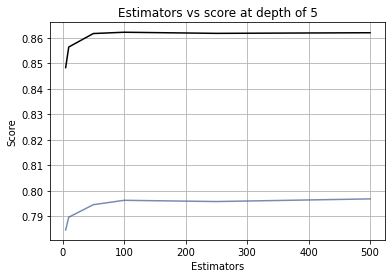

In [ ]:
estimators = [5,10,50,100,250,500]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(X_train_encode,y_train)
    train_sc = f1_score(y_train,clf.predict(X_train_encode),average='macro')
    test_sc = f1_score(y_test,clf.predict(X_test_encode),average='macro')
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score',color='black')
plt.plot(estimators,test_scores,label='Test Score',color='#425a90',alpha=0.7)
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')
plt.grid()

depth =  3 Train Score 0.8229182137899087 test Score 0.7626631883898214
depth =  9 Train Score 0.8768412814477038 test Score 0.8055227907760845
depth =  11 Train Score 0.8776910412757344 test Score 0.8041546148784972
depth =  15 Train Score 0.8776866740714329 test Score 0.8034038211809486
depth =  20 Train Score 0.8778826837987468 test Score 0.803591094147101
depth =  35 Train Score 0.8779081890159492 test Score 0.8028553596843356
depth =  50 Train Score 0.8778663113061898 test Score 0.8028553596843356
depth =  70 Train Score 0.8778663113061898 test Score 0.8028553596843356
depth =  130 Train Score 0.8778663113061898 test Score 0.8028553596843356


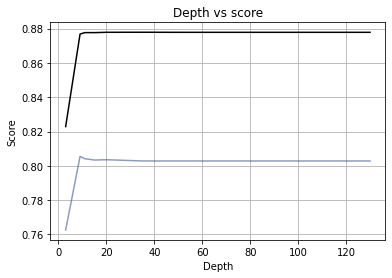

In [ ]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(X_train_encode,y_train)
    train_sc = f1_score(y_train,clf.predict(X_train_encode),average='macro')
    test_sc = f1_score(y_test,clf.predict(X_test_encode),average='macro')
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score',color='black')
plt.plot(depths,test_scores,label='Test Score',color='#425a90',alpha=0.6)
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score')
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1_macro',random_state=25,return_train_score=True )

rf_random.fit(X_train_encode,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.869705   0.86978126 0.86934033 0.86987059 0.86907663]
mean train scores [0.87793813 0.87823902 0.87626858 0.87692678 0.87985437]


In [ ]:
# printing best parameters and score
print("Best Parameters: ",rf_random.best_params_)
print("Best Score: ",rf_random.best_score_)

Best Parameters:  {'max_depth': 13, 'min_samples_leaf': 49, 'min_samples_split': 165, 'n_estimators': 108}
Best Score:  0.8698705892967556


In [ ]:

# Fitting the model on best parameters
rf_classifier = RandomForestClassifier(max_depth = 13, min_samples_leaf = 49, min_samples_split = 165, n_estimators = 108,random_state=25,
                           n_jobs=-1)
rf_classifier.fit(X_train_encode,y_train)

y_train_pred = rf_classifier.predict(X_train_encode)
y_test_pred = rf_classifier.predict(X_test_encode)

# printing train and test scores
print('Train f1 score',f1_score(y_train,y_train_pred,average='macro'))
print('Test f1 score',f1_score(y_test,y_test_pred,average='macro'))

Train f1 score 0.8774487288720161
Test f1 score 0.8032629907003228


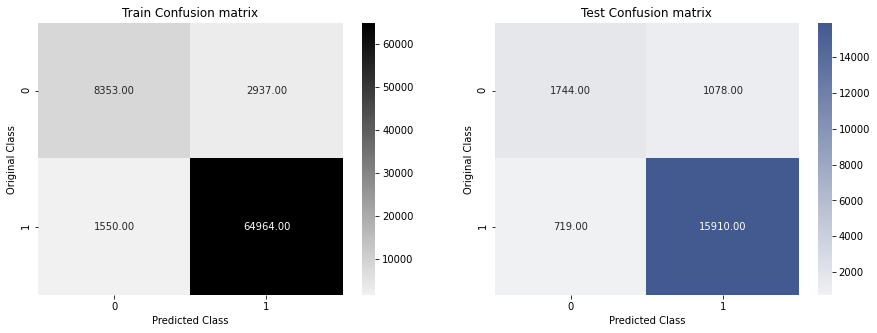

In [ ]:
confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred,'rf.png')

In [ ]:
# save the model to disk
filename = '/content/drive/MyDrive/case study/models/randomf.sav'
joblib.dump(rf_classifier, filename)

['/content/drive/MyDrive/case study/models/randomf.sav']

## 4.LGBM

Estimators =  1 Train Score 0.4608849900913261 test Score 0.46089246119733923
Estimators =  3 Train Score 0.4608849900913261 test Score 0.46089246119733923
Estimators =  5 Train Score 0.4608849900913261 test Score 0.46089246119733923
Estimators =  10 Train Score 0.8527908646965197 test Score 0.7795356610146007
Estimators =  50 Train Score 0.8815653668527856 test Score 0.8042926427631747
Estimators =  100 Train Score 0.887269982513814 test Score 0.8050377016191237
Estimators =  250 Train Score 0.911807695468607 test Score 0.8036228169737664
Estimators =  500 Train Score 0.9444291804782906 test Score 0.8010753511424802
Estimators =  1000 Train Score 0.9576994317083201 test Score 0.7991633195885934


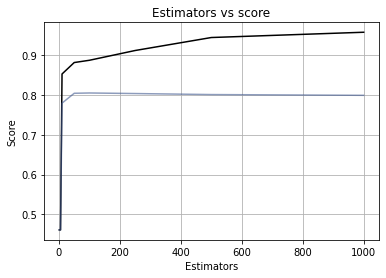

In [ ]:
# Variation of score with estimators used in LGBM with other parameters set to default value
estimators = [1,3,5,10,50,100,250,500,1000]
train_scores = []
test_scores = []
for i in estimators:
    clf = LGBMClassifier(n_estimators=i, n_jobs=-1,random_state=25)
    clf.fit(X_train_encode,y_train)
    train_sc = f1_score(y_train,clf.predict(X_train_encode),average='macro')
    test_sc = f1_score(y_test,clf.predict(X_test_encode),average='macro')
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score',color='black')
plt.plot(estimators,test_scores,label='Test Score',color='#425a90',alpha=0.6)
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score')
plt.grid()

In [ ]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# Prameter tuning of the LGBM parameters using RandonSearch CV
x_cfl=LGBMClassifier(random_state=25,n_jobs=-1)

prams={
    'learning_rate':[0.001,0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[1,3,5,10,50,100,250,500,1000],
     'max_depth':[3,5,10,15,20,50],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl1=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,random_state=25,scoring='f1_macro',
                               return_train_score=True)
random_cfl1.fit(X_train_encode,y_train)

print('mean test scores',random_cfl1.cv_results_['mean_test_score'])
print('mean train scores',random_cfl1.cv_results_['mean_train_score'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.4min finished


mean test scores [0.86547853 0.87051832 0.87032389 0.86893712 0.46088499 0.86847912
 0.86961699 0.46088499 0.8152882  0.46088499]
mean train scores [0.93449821 0.88242659 0.87972026 0.88836053 0.46088499 0.89321307
 0.87461157 0.46088499 0.82309595 0.46088499]


In [ ]:
# printing best parameters and score
print("Best Parameters: ",random_cfl1.best_params_)
print("Best Score: ",random_cfl1.best_score_)

Best Parameters:  {'subsample': 0.5, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.1}
Best Score:  0.870518321178464


In [ ]:
# Fitting the model on best parameters
lgbm = LGBMClassifier(n_estimators=500, max_depth=10,subsample=0.5,learning_rate=0.01,colsample_bytree=0.1,random_state=25,
                      n_jobs=-1)
lgbm.fit(X_train_encode,y_train)


y_train_pred = lgbm.predict(X_train_encode)
y_test_pred = lgbm.predict(X_test_encode)

# printing train and test scores
print('Train f1 score',f1_score(y_train,y_train_pred,average='macro'))
print('Test f1 score',f1_score(y_test,y_test_pred,average='macro'))

Train f1 score 0.8805369929197495
Test f1 score 0.8063334961377676


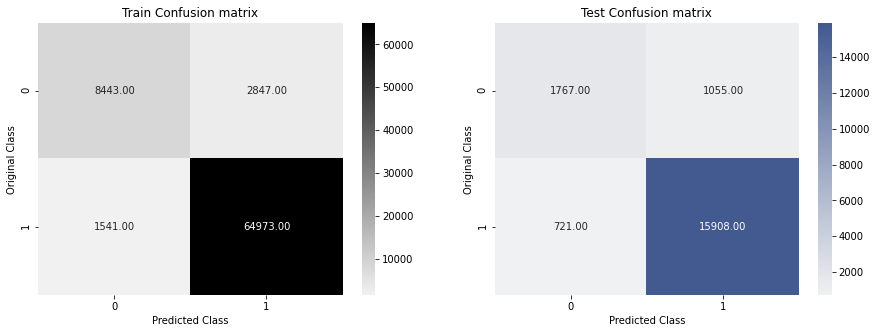

In [ ]:
confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred,'lgbm.png')

In [ ]:
filename = '/content/drive/MyDrive/case study/models/lgbm.sav'
joblib.dump(lgbm, filename)

['/content/drive/MyDrive/case study/models/lgbm.sav']

## 5.XGB Classifier

In [ ]:
from xgboost import XGBClassifier
import random
clf = XGBClassifier()
param_dist = {"n_estimators":sp_randint(105,125),
              "eta":[round(random.uniform(0.1, 1.0 ), 1) for i in range(0,20)]
              }
xg_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=3,scoring='f1_macro',random_state=25,return_train_score=True)


xg_random.fit(X_train_encode,y_train)
print('mean test scores',xg_random.cv_results_['mean_test_score'])
print('mean train scores',xg_random.cv_results_['mean_train_score'])

mean test scores [0.86772465 0.86785741 0.86768704 0.8673134  0.86747848]
mean train scores [0.87655227 0.87655871 0.8760196  0.87594627 0.87599905]


In [ ]:
print(xg_random.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=123, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [ ]:
clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=123, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)



In [ ]:
clf.fit(X_tr,y_train)
y_train_pred = clf.predict(X_tr)
y_test_pred = clf.predict(X_te)

In [ ]:

# printing train and test scores
print('Train f1 score',f1_score(y_train,y_train_pred,average='macro'))
print('Test f1 score',f1_score(y_test,y_test_pred,average='macro'))

Train f1 score 0.8062058946636459
Test f1 score 0.7818943463057906


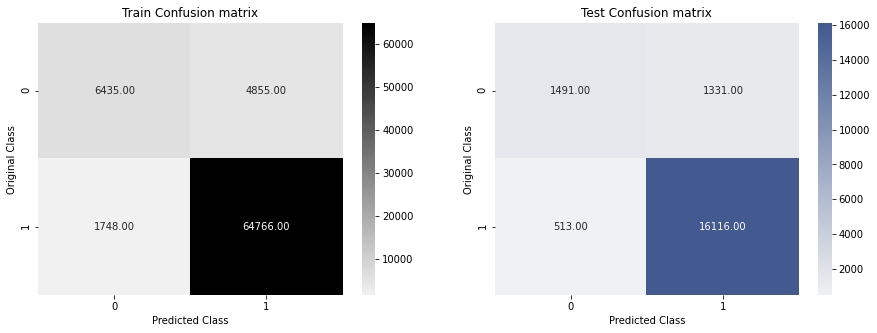

In [ ]:
confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred,'xgboost.png')

In [ ]:
filename = '/content/drive/MyDrive/case study/models/xgboost.sav'
joblib.dump(clf, filename)

['/content/drive/MyDrive/case study/models/xgboost.sav']

### 6. Adaboost Model

In [ ]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# Prameter tuning of the LGBM parameters using RandonSearch CV
x_cfl=AdaBoostClassifier(random_state=25)

prams={
    'learning_rate':[0.001,0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[1,3,5,10,50,100,250,500,1000]
}
random_cfl1=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,random_state=25,scoring='f1_macro',
                               return_train_score=True)
random_cfl1.fit(X_train_encode,y_train)

print('mean test scores',random_cfl1.cv_results_['mean_test_score'])
print('mean train scores',random_cfl1.cv_results_['mean_train_score'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 36.6min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 49.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 68.2min finished


mean test scores [0.81617065 0.81548033 0.81406621 0.81406621 0.81073878 0.81559259
 0.81273864 0.85922691 0.81544965 0.86096781]
mean train scores [0.81663367 0.81649262 0.81518355 0.81518355 0.8111668  0.81613359
 0.812844   0.86040939 0.81619281 0.86273996]


In [ ]:
# printing best parameters and score
print("Best Parameters: ",random_cfl1.best_params_)
print("Best Score: ",random_cfl1.best_score_)

Best Parameters:  {'n_estimators': 500, 'learning_rate': 0.05}
Best Score:  0.8609678086080766


In [ ]:
# Fitting the model on best parameters
ada = AdaBoostClassifier(n_estimators=500, learning_rate=0.05, random_state=25)
ada.fit(X_train_encode,y_train)

y_train_pred = ada.predict(X_train_encode)
y_test_pred = ada.predict(X_test_encode)

# printing train and test scores
print('Train f1 score',f1_score(y_train,y_train_pred,average='macro'))
print('Test f1 score',f1_score(y_test,y_test_pred,average='macro'))

Train f1 score 0.8629085003364181
Test f1 score 0.7985629708732479


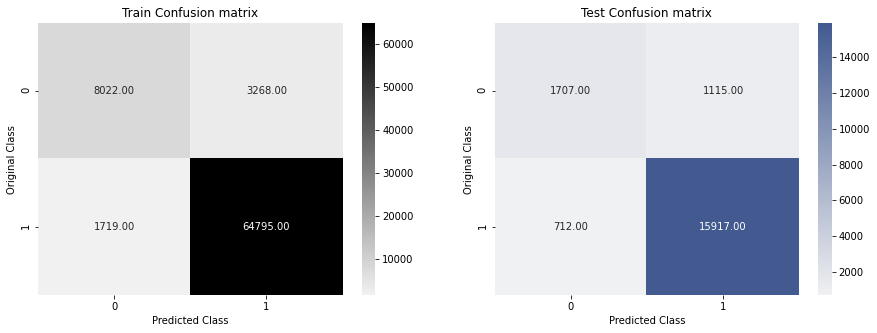

In [ ]:
confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred,'ada.png')

In [ ]:
filename = '/content/drive/MyDrive/case study/models/ada.sav'
joblib.dump(ada, filename)

['/content/drive/MyDrive/case study/models/ada.sav']

## 7.Catboost Classifier

In [ ]:
from catboost import CatBoostClassifier
learning_rate = [0.001,0.01,0.1]
max_depth = [5,10,15]

#Loop for the Tuning
for lr in learning_rate:
    for n in max_depth:
        clf = CatBoostClassifier(learning_rate=lr,max_depth = n,verbose = False)

        clf.fit(X_train_encode,y_train)

        #y_pred = (clf.predict_proba(X_test)[:, 1] >= 0.21).astype('int')
        Y_pred = clf.predict(X_train_encode)
        y_pred = clf.predict(X_test_encode)
        print(f"Train f1 score at learning rate {lr} and max_depth {n} is {f1_score(y_train, Y_pred,average='macro')}")
        print(f"Test f1 score at learning rate {lr} and max_depth {n} is {f1_score(y_test, y_pred,average='macro')}")
        print("-"*50)

Train f1 score at learning rate 0.001 and max_depth 5 is 0.8671317844968727
Test f1 score at learning rate 0.001 and max_depth 5 is 0.8037009139263656
--------------------------------------------------
Train f1 score at learning rate 0.001 and max_depth 10 is 0.873491923891086
Test f1 score at learning rate 0.001 and max_depth 10 is 0.8052594369922508
--------------------------------------------------
Train f1 score at learning rate 0.001 and max_depth 15 is 0.8843754862374552
Test f1 score at learning rate 0.001 and max_depth 15 is 0.8045287713262363
--------------------------------------------------
Train f1 score at learning rate 0.01 and max_depth 5 is 0.8763461174771061
Test f1 score at learning rate 0.01 and max_depth 5 is 0.805690281820876
--------------------------------------------------
Train f1 score at learning rate 0.01 and max_depth 10 is 0.8954534315038922
Test f1 score at learning rate 0.01 and max_depth 10 is 0.8046964171679296
-----------------------------------------

In [ ]:
from catboost import CatBoostClassifier
n_estimators = [100,200,500]
class_weights = [{0:1,1:2},{0:1,1:4},{0:1,1:6}]

#Loop for the Tuning
for n in n_estimators:
    for l in class_weights:
        clf = CatBoostClassifier(learning_rate=0.1,max_depth = 15,n_estimators = n,class_weights = l,verbose = False)
        clf.fit(X_train_encode,y_train)

        #y_pred = (clf.predict_proba(X_test)[:, 1] >= 0.21).astype('int')
        y_train_pred = clf.predict(X_train_encode)
        y_test_pred= clf.predict(X_test_encode)
        print(f"Train f1 score at n_estimators {n} and  class_weights {l} is {f1_score(y_train, y_train_pred,average='macro')}")
        print(f"Test f1 score at n_estimators {n} and class_weights {l} is {f1_score(y_test, y_test_pred,average='macro')}")
        print("-"*50)

Train f1 score at n_estimators 100 and  class_weights {0: 1, 1: 2} is 0.9261981184750693
Test f1 score at n_estimators 100 and class_weights {0: 1, 1: 2} is 0.7897664765934407
--------------------------------------------------
Train f1 score at n_estimators 100 and  class_weights {0: 1, 1: 4} is 0.9046092086089003
Test f1 score at n_estimators 100 and class_weights {0: 1, 1: 4} is 0.7760937523544432
--------------------------------------------------
Train f1 score at n_estimators 100 and  class_weights {0: 1, 1: 6} is 0.885049171172361
Test f1 score at n_estimators 100 and class_weights {0: 1, 1: 6} is 0.7682022818589821
--------------------------------------------------
Train f1 score at n_estimators 200 and  class_weights {0: 1, 1: 2} is 0.9422465020598454
Test f1 score at n_estimators 200 and class_weights {0: 1, 1: 2} is 0.7925053645163538
--------------------------------------------------
Train f1 score at n_estimators 200 and  class_weights {0: 1, 1: 4} is 0.9290554684186333
Test

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
clf = CatBoostClassifier(learning_rate=0.01,max_depth = 15,n_estimators = 100,class_weights ={0: 1, 1: 4},verbose = False)
clf.fit(X_train_encode,y_train)

In [ ]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,clf.predict(X_train_encode),average='macro'))
print('Test f1 score',f1_score(y_test,clf.predict(X_test_encode),average='macro'))

Train f1 score 0.8163487913899979
Test f1 score 0.7501551782310858


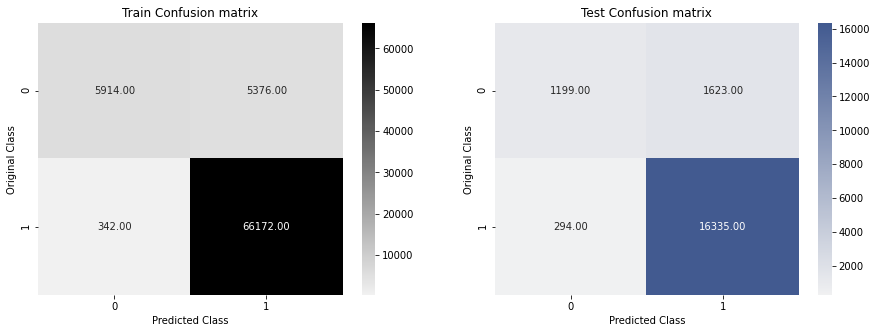

In [ ]:
confusion_matrices_plot(y_train,clf.predict(X_train_encode),y_test,clf.predict(X_test_encode),'xgb.png')

In [ ]:
#saving the model
filename = '/content/drive/MyDrive/case study/models/catboost.sav'
joblib.dump(clf, filename)

['/content/drive/MyDrive/case study/models/catboost.sav']

### 8.StackingClassifier

In [ ]:
#https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/
# defining the base models
est0 = list()
est0.append(('lr', SGDClassifier(loss='log', alpha=0.1, n_jobs=-1, random_state=25)))
est0.append(('svm', SGDClassifier(loss='hinge', alpha=1, n_jobs=-1, random_state=25)))
est0.append(('dt', DecisionTreeClassifier(max_depth = 135, min_samples_leaf = 28, min_samples_split = 193,random_state=25)))
est0.append(('rf', RandomForestClassifier(max_depth = 13, min_samples_leaf = 49, min_samples_split = 165, n_estimators = 108,random_state=25,
                           n_jobs=-1)))
est0.append(('xgb', XGBClassifier(n_estimators=123, max_depth=3,subsample= 1,learning_rate=0.1,colsample_bytree=1,random_state=25,
                      n_jobs=-1)))

In [ ]:
est_final= SGDClassifier(loss='log',n_jobs=-1, random_state=25)

In [ ]:
clf = StackingClassifier(estimators=est0, final_estimator = est_final, n_jobs=-1)

clf.fit(X_train_encode,y_train)


y_train_pred = clf.predict(X_train_encode)
y_test_pred = clf.predict(X_test_encode)

# printing train and test scores
print('Train f1 score',f1_score(y_train,y_train_pred,average='macro'))
print('Test f1 score',f1_score(y_test,y_test_pred,average='macro'))

Train f1 score 0.8749240548287187
Test f1 score 0.7995396369898682


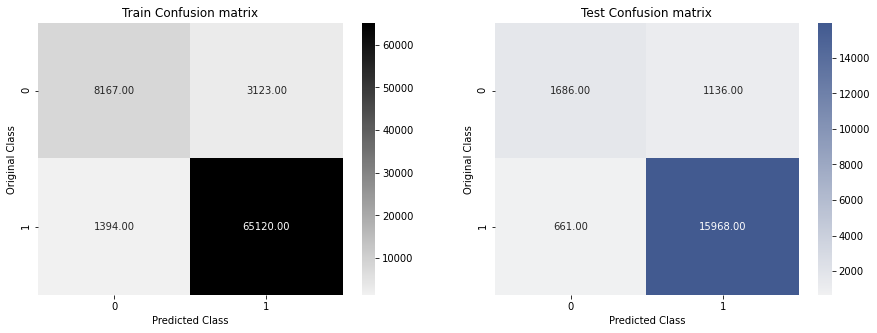

In [ ]:
confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred,'stack.png')

In [ ]:
#saving the model
filename = '/content/drive/MyDrive/case study/models/stackcl.sav'
joblib.dump(clf, filename)

['/content/drive/MyDrive/case study/models/stackcl.sav']

### 9.VotingClassifier

In [ ]:
#https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/
# defining the base models
est0 = list()
est0.append(('lr', SGDClassifier(loss='log', alpha=0.1, n_jobs=-1, random_state=25)))
est0.append(('dt', DecisionTreeClassifier(max_depth = 135, min_samples_leaf = 28, min_samples_split = 193,random_state=25)))
est0.append(('rf', RandomForestClassifier(max_depth = 13, min_samples_leaf = 49, min_samples_split = 165, n_estimators = 108,random_state=25,
                           n_jobs=-1)))
est0.append(('xgb', XGBClassifier(n_estimators=123, max_depth=3,subsample= 1,learning_rate=0.1,colsample_bytree=1,random_state=25,
                      n_jobs=-1)))

In [ ]:
#https://www.geeksforgeeks.org/ml-voting-classifier-using-sklearn/
# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = est0, voting ='hard')
vot_hard.fit(X_train_encode, y_train)
y_train_pred = vot_hard.predict(X_train_encode)
y_test_pred = vot_hard.predict(X_test_encode)

# printing train and test scores
print('Train f1 score',f1_score(y_train,y_train_pred,average='macro'))
print('Test f1 score',f1_score(y_test,y_test_pred,average='macro'))

Train f1 score 0.8788060839390608
Test f1 score 0.806804323724443


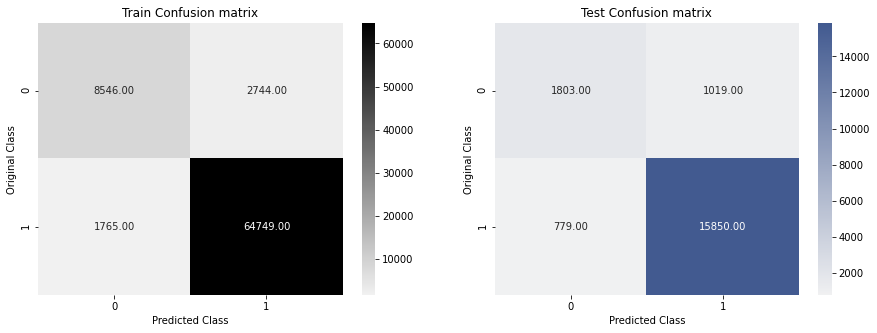

In [ ]:
confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred,'votclf_1.png')

In [ ]:
#saving the model
filename = '/content/drive/MyDrive/case study/models/vot_hard.sav'
joblib.dump(vot_hard, filename)

['/content/drive/MyDrive/case study/models/vot_hard.sav']

In [ ]:
# Voting Classifier with hard voting
vot_soft = VotingClassifier(estimators = est0, voting ='soft')
vot_soft.fit(X_train_encode, y_train)
y_train_pred = vot_soft.predict(X_train_encode)
y_test_pred = vot_soft.predict(X_test_encode)

# printing train and test scores
print('Train f1 score',f1_score(y_train,y_train_pred,average='macro'))
print('Test f1 score',f1_score(y_test,y_test_pred,average='macro'))

Train f1 score 0.8776384471346554
Test f1 score 0.8051520742812928


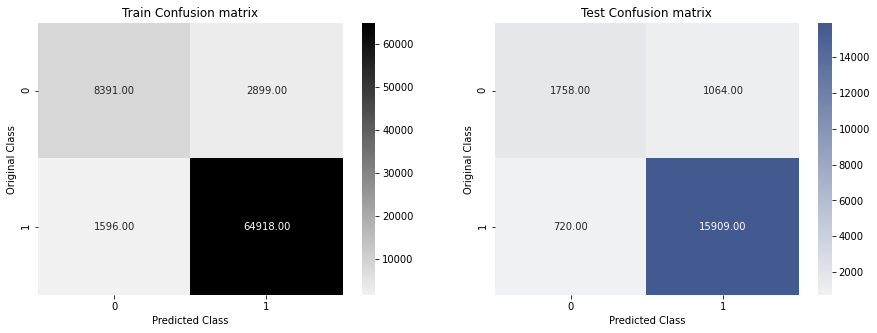

In [ ]:
confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred,'votclf_2.png')

In [ ]:
#saving the model
filename = '/content/drive/MyDrive/case study/models/vot_soft.sav'
joblib.dump(vot_soft, filename)

['/content/drive/MyDrive/case study/models/vot_soft.sav']

### Summary

In [ ]:
from prettytable import PrettyTable 
x = PrettyTable()
x.field_names = ["Model", "Hyper parameter", "test f1-Score"]
x.add_row(['logistic ','alpha=0.1','0.802699'])
x.add_row(['Regression',' ',' '])
x.add_row([' ',' ',' '])
x.add_row(['Linear SVM','alpha=1','0.793024'])
x.add_row([' ',' ',' '])
x.add_row(['Decision Tree','max_depth=135','0.802874'])
x.add_row([' ','min_samples_leaf= 28,min_samples_split=193',' '])
x.add_row([' ',' ',' '])
x.add_row(['Random Forest','max_depth =13, min_samples_leaf=49','0.803262'])
x.add_row([' ','min_samples_split =165,n_estimators=108',' '])
x.add_row([' ',' ',' '])
x.add_row(['XGBclassifier','n_estimators=109, max_depth=3','0.781894'])
x.add_row([' ','subsample=0.5,learning_rate=0.1,colsample_bytree=1',' '])
x.add_row([' ',' ',' '])
x.add_row(['LGBMClassifier','n_estimators=500, max_depth=10','0.806333'])
x.add_row([' ','subsample=0.5,learning_rate=0.01,colsample_bytree=0.1',' '])
x.add_row([' ',' ',' '])
x.add_row(['AdaBoost','n_estimators=500, learning_rate=0.05','0.798562'])
x.add_row([' ',' ',' '])
x.add_row(['CATBoost','earning_rate=0.01,max_depth = 15','0.750155'])
x.add_row([' ','n_estimators = 100,class_weights ={0: 1, 1: 4}',' '])
x.add_row([' ',' ',' '])
x.add_row(['StackingClassifier','estimators=est0, final_estimator = est_final','0.799539'])
x.add_row([' ',' ',' '])
x.add_row(['VotingClassifier',' ',' '])
x.add_row(['vot_hard','estimators = est0, voting =hard','0.80680'])
x.add_row(['vot_soft','estimators = est0, voting = soft','0.80515'])
x.add_row([' ',' ',' '])
print(x)

+--------------------+-------------------------------------------------------+---------------+
|       Model        |                    Hyper parameter                    | test f1-Score |
+--------------------+-------------------------------------------------------+---------------+
|     logistic       |                       alpha=0.1                       |    0.802699   |
|     Regression     |                                                       |               |
|                    |                                                       |               |
|     Linear SVM     |                        alpha=1                        |    0.793024   |
|                    |                                                       |               |
|   Decision Tree    |                     max_depth=135                     |    0.802874   |
|                    |       min_samples_leaf= 28,min_samples_split=193      |               |
|                    |                            